In [1]:
import tensorflow as tf
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os



os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import sys

import scipy
import scipy.io
import time



import logging

import os.path
import shutil
from datetime import datetime
import pickle

class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

# Define the exact solution and its derivatives
def u(x, a, c):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(np.pi * x) * np.cos(c * np.pi * t) + a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -  c * np.pi * np.sin(np.pi * x) * np.sin(c * np.pi * t) -  a * 4 * c * np.pi * np.sin(2 * c * np.pi* x) * np.sin(4 * c * np.pi * t)
    return u_t

def u_tt(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -(c * np.pi)**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - a * (4 * c * np.pi)**2 *  np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) -  a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - c**2 * u_xx
    return residual



In [2]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c ,mode ,  sess):
        # Normalization 


        self.mode = mode

        self.dirname, logpath = self.make_output_dir()
        self.logger = self.get_logger(logpath)     

        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        self.activFun = 'tanh'
        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        self.sess = sess
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # weights
        self.lam_u_val = np.array(2.0)
        self.lam_ut_val = np.array(2.0)
        self.lam_res_val = np.array(1.0)
        self.lam_bc1_val = np.array(2.0)
        self.lam_bc2_val = np.array(2.0)
      
        # Wave constant
        self.c = tf.constant(c, dtype=tf.float32)
        

        # Define Tensorflow session
        self.sess = sess #tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.lam_u_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_ut_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        # self.lam_r_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_bc1_tf = tf.placeholder(tf.float32, shape=self.lam_bc1_val.shape)
        self.lam_bc2_tf = tf.placeholder(tf.float32, shape=self.lam_bc2_val.shape)
        self.lam_res_tf = tf.placeholder(tf.float32, shape=self.lam_res_val.shape)


        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)


        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)
        
        
        # Boundary loss and Initial loss
        self.loss_ics_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ics_ut = tf.reduce_mean(tf.square( tf.gradients(self.u_ics_pred, self.t_ics_tf)[0] / self.sigma_t) )
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred)) #+ tf.reduce_mean(tf.square(self.u_bc2_pred))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss =  self.lam_res_val * self.loss_res + self.lam_bc1_tf * self.loss_bc1 +  self.lam_bc2_tf * self.loss_bc2 + self.lam_u_tf * (self.loss_ics_u + self.loss_ics_ut )

        self.prev_loss = 1000000000
        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,  1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
        

        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bc1 , self.loss_bc2 , self.loss_ics_u, self.loss_ics_ut] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bc1", "loss_bc2", "loss_ics_u" , "loss_ics_ut"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)

        self.dict_gradients_res_layers = self.generate_grad_dict()
        self.dict_gradients_bcs1_layers = self.generate_grad_dict()
        self.dict_gradients_bcs2_layers = self.generate_grad_dict()
        self.dict_gradients_ics_layers = self.generate_grad_dict()

        # Gradients Storage
        self.grad_res = []
        self.grad_ics = []
        self.grad_bcs1 = []
        self.grad_bcs2 = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weights[i])[0])
            self.grad_bcs1.append(tf.gradients(self.loss_bc1, self.weights[i])[0])
            self.grad_bcs2.append(tf.gradients(self.loss_bc2, self.weights[i])[0])
            self.grad_ics.append(tf.gradients(self.loss_ics_u, self.weights[i])[0])

        self.max_grad_res_list = []
        self.mean_grad_bcs1_list = []
        self.mean_grad_bcs2_list = []
        self.mean_grad_ics_list = []

        for i in range(len(self.layers) - 1):
            self.max_grad_res_list.append(tf.math.reduce_std(tf.abs(self.grad_res[i]))) 
            self.mean_grad_bcs1_list.append(tf.math.reduce_std(tf.abs(self.grad_bcs1[i])))
            self.mean_grad_bcs2_list.append(tf.math.reduce_std(tf.abs(self.grad_bcs2[i])))
            self.mean_grad_ics_list.append(tf.math.reduce_std(tf.abs(self.grad_ics[i])))

        self.mean_grad_res = tf.math.reduce_std(tf.stack(self.max_grad_res_list))
        self.mean_grad_bcs1 = tf.math.reduce_std(tf.stack(self.mean_grad_bcs1_list))
        self.mean_grad_bcs2 = tf.math.reduce_std(tf.stack(self.mean_grad_bcs2_list))
        self.mean_grad_ics = tf.math.reduce_std(tf.stack(self.mean_grad_ics_list))
        
        self.adaptive_constant_bcs1 = self.mean_grad_bcs1
        self.adaptive_constant_bcs2 = self.mean_grad_bcs2
        self.adaptive_constant_ics = self.mean_grad_ics
        self.adaptive_constant_res = self.mean_grad_res

         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,  dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
        # H = (tf.concat(inputs, 1) - self.X_mean)/self.X_std
        # num_layers = len(layers)
        # for l in range(0,num_layers-1):
        #     W = weights[l]
        #     b = biases[l]
        #     V = W/tf.norm(W, axis = 0, keepdims=True)
        #     H = tf.matmul(H, V)
        #     H = H + b
        #     if l < num_layers-2:
        #             if(self.activFun == 'xsig'):
        #                 H = H*tf.sigmoid(H)
        #             elif self.activFun == 'hard_swish':
        #                 H = H * tf.nn.relu6(H+3) * 0.16666667
        #             else:
        #                 H = tf.tanh(H)
                
        # Y = tf.split(H, num_or_size_splits=H.shape[1], axis=1)
        # return H
################################################################################################
    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1),  self.layers, self.weights, self.biases)
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.c, self.sigma_t,  self.sigma_x)
        return residual
    
    

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

        # Trains the model by minimizing the MSE loss

    def trainmb(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        itValues = [1,100,1000,39999]
        start_time = timeit.default_timer()
        for it in range(1 , nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.lam_u_tf: self.lam_u_val,
                       self.lam_bc1_tf: self.lam_bc1_val,
                       self.lam_bc2_tf: self.lam_bc2_val,
                       self.lam_res_tf: self.lam_res_val
                       }

            # Run the Tensorflow session to minimize the loss
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)
            [loss ,  loss_res,  loss_bc1 , loss_bc2 , loss_ics_u , loss_ics_ut]  = batch_losses

            # Print
            if  it % 100 == 0:
              
                    elapsed = timeit.default_timer() - start_time

                    print('It: %d, Loss: %.3e,  loss_bc1: %.3e,  loss_bc2: %.3e, loss_ics_u: %.3e, loss_ics_ut: %.3e,  Loss_res: %.3e , Time: %.2f' %(it, loss, loss_bc1 , loss_bc2 , loss_ics_u, loss_ics_ut , loss_res , elapsed))
            if  ( loss_bc1 + loss_bc2 + loss_ics_u + loss_ics_ut) <  self.prev_loss :
               
                adaptive_constant_res , adaptive_constant_bcs1, adaptive_constant_bcs2 , adaptive_constant_ics = self.sess.run( [self.adaptive_constant_res ,
                                                                                                                                  self.adaptive_constant_bcs1,
                                                                                                                                    self.adaptive_constant_bcs2,
                                                                                                                                      self.adaptive_constant_ics  ], tf_dict)
                # self.print adaptive weights during training
                self.lam_res_val = loss_res / adaptive_constant_res #* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                self.lam_u_val = (loss_ics_u + loss_ics_ut) / adaptive_constant_ics #* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_ics_val
                self.lam_bc1_val = (loss_bc1 ) /adaptive_constant_bcs1 #* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val
                self.lam_bc2_val = (loss_bc2 ) /adaptive_constant_bcs2 #* ( 1.0 - self.rate) + self.rate * self.adaptive_constant_bcs_val


                self.print('lam_res_val: {:.3e}'.format(self.lam_res_val))
                self.print('lam_u_val: {:.3e}'.format(self.lam_u_val))
                self.print('lam_bc1_val: {:.3e}'.format(self.lam_bc1_val))
                self.print('lam_bc2_val: {:.3e}'.format(self.lam_bc2_val))

            
                self.prev_loss = ( loss_bc1 + loss_bc2 + loss_ics_u + loss_ics_ut)

            sys.stdout.flush()
            start_time =      timeit.default_timer()
            if it in itValues:
                    self.plot_layerLoss(tf_dict , it)
                    self.print("Gradients information stored ...")

            sys.stdout.flush()
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])


    def train(self, nIter , bcbatch_size , ubatch_size):

        start_time = timeit.default_timer()

        # Fetch boundary mini-batches
        X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, bcbatch_size)
        X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], bcbatch_size )
        X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], bcbatch_size )
        
        # Fetch residual mini-batch
        X_res_batch, _ = self.fetch_minibatch(self.res_sampler, ubatch_size)
        # print("inside trainmb: " , X_res_batch.shape)
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                    self.u_ics_tf: u_ics_batch,
                    self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                    self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                    self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                    self.lam_u_tf: self.lam_u_val,
                       self.lam_bc1_tf: self.lam_bc1_val,
                       self.lam_bc2_tf: self.lam_bc1_val,
                    self.lam_res_tf: self.lam_res_val,
                    }
        
        for it in range(nIter):

            # Run the Tensorflow session to minimize the loss
            _ , loss = self.sess.run([self.train_op,self.loss  ], tf_dict)

            if  it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss_bc1 , loss_bc2 , loss_ics_u , loss_ics_ut , loss_res = self.sess.run( [ self.loss_bc1 ,self.loss_bc2 , self.loss_ics_u, self.loss_ics_ut, self.loss_res ] , tf_dict)

                print('It: %d, Loss: %.3e,  loss_bc1: %.3e,  loss_bc2: %.3e, loss_ics_u: %.3e, loss_ics_ut: %.3e,  Loss_res: %.3e , Time: %.2f' %(it, loss, loss_bc1 , loss_bc2 , loss_ics_u, loss_ics_ut , loss_res , elapsed))
                
            if  loss <  self.prev_loss :

                alpha   = 10000
                self.lam_bc_val = alpha *  (loss_bc1 + loss_bc2 )
                # self.lam_bc2_val = alpha * loss_bc2
                self.lam_u_val = alpha * (loss_ics_u + loss_ics_ut )
                self.lam_res_val = 100 *loss_res
                
                print('loss_bc1: {:.3e}'.format(self.lam_bc_val))
                print('loss_bc2: {:.3e}'.format(self.lam_bc2_val))
                print('loss_ics_u: {:.3e}'.format(self.lam_u_val))
                print('loss_res_val: {:.3e}'.format(self.lam_res_val))

            start_time =   timeit.default_timer()
            sys.stdout.flush()


    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

        # Evaluates predictions at test points

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star
    
   ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   #  


   #  
    def plot_layerLoss(self , tf_dict , epoch):
        ## Gradients #
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res , grad_bc1, grad_bc2  , grad_ics  = self.sess.run([ self.grad_res[i],self.grad_bcs1[i],self.grad_bcs2[i],self.grad_ics[i]], feed_dict=tf_dict)

            # save gradients of loss_r and loss_u
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res.flatten())
            self.dict_gradients_bcs1_layers['layer_' + str(i + 1)].append(grad_bc1.flatten())
            self.dict_gradients_bcs2_layers['layer_' + str(i + 1)].append(grad_bc2.flatten())
            self.dict_gradients_ics_layers['layer_' + str(i + 1)].append(grad_ics.flatten())

        num_hidden_layers = num_layers -1
        cnt = 1
        fig = plt.figure(4, figsize=(13, 4))
        for j in range(num_hidden_layers):
            ax = plt.subplot(1, num_hidden_layers, cnt)
            ax.set_title('Layer {}'.format(j + 1))
            ax.set_yscale('symlog')
            gradients_res = self.dict_gradients_res_layers['layer_' + str(j + 1)][-1]
            gradients_bc1 = self.dict_gradients_bcs1_layers['layer_' + str(j + 1)][-1]
            gradients_bc2 = self.dict_gradients_bcs2_layers['layer_' + str(j + 1)][-1]
            gradients_ics = self.dict_gradients_ics_layers['layer_' + str(j + 1)][-1]

            sns.distplot(gradients_res, hist=False,kde_kws={"shade": False},norm_hist=True,  label=r'$\nabla_\theta \mathcal{L}_r$')

            sns.distplot(gradients_bc1, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc1}}$')
            sns.distplot(gradients_bc2, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{bc2}}$')
            sns.distplot(gradients_ics, hist=False,kde_kws={"shade": False},norm_hist=True,   label=r'$\nabla_\theta \mathcal{L}_{u_{ics}}$')

            #ax.get_legend().remove()
            ax.set_xlim([-1.0, 1.0])
            #ax.set_ylim([0, 150])
            cnt += 1
        handles, labels = ax.get_legend_handles_labels()

        fig.legend(handles, labels, loc="center",  bbox_to_anchor=(0.5, -0.03),borderaxespad=0,bbox_transform=fig.transFigure, ncol=4)
        text = 'layerLoss_epoch' + str(epoch) +'.png'
        plt.savefig(os.path.join(self.dirname,text) , bbox_inches='tight')
        plt.close("all")

    # #########################
    # def make_output_dir(self):
        
    #     if not os.path.exists("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints"):
    #         os.mkdir("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints")
    #     dirname = os.path.join("/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
    #     os.mkdir(dirname)
    #     text = 'output.log'
    #     logpath = os.path.join(dirname, text)
    #     shutil.copyfile('/okyanus/users/afarea/PINN/Adaptive_PINN/IB_PINN/M2.py', os.path.join(dirname, 'M2.py'))

    #     return dirname, logpath
    
    # # ###########################################################
    def make_output_dir(self):
        
        if not os.path.exists("checkpoints"):
            os.mkdir("checkpoints")
        dirname = os.path.join("checkpoints", datetime.now().strftime("%b-%d-%Y_%H-%M-%S-%f_") + self.mode)
        os.mkdir(dirname)
        text = 'output.log'
        logpath = os.path.join(dirname, text)
        shutil.copyfile('M5.ipynb', os.path.join(dirname, 'M5.ipynb'))
        return dirname, logpath
    

    def get_logger(self, logpath):
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)
        sh = logging.StreamHandler()
        sh.setLevel(logging.DEBUG)        
        sh.setFormatter(logging.Formatter('%(message)s'))
        fh = logging.FileHandler(logpath)
        logger.addHandler(sh)
        logger.addHandler(fh)
        return logger


   
    def print(self, *args):
        for word in args:
            if len(args) == 1:
                self.logger.info(word)
            elif word != args[-1]:
                for handler in self.logger.handlers:
                    handler.terminator = ""
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32: 
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)
            else:
                for handler in self.logger.handlers:
                    handler.terminator = "\n"
                if type(word) == float or type(word) == np.float64 or type(word) == np.float32:
                    self.logger.info("%.4e" % (word))
                else:
                    self.logger.info(word)


    def plot_loss_history(self , path):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            self.print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.savefig(path)
        #plt.show()
       #######################
    def save_NN(self):

        uv_weights = self.sess.run(self.weights)
        uv_biases = self.sess.run(self.biases)

        with open(os.path.join(self.dirname,'model.pickle'), 'wb') as f:
            pickle.dump([uv_weights, uv_biases], f)
            self.print("Save uv NN parameters successfully in %s ..." , self.dirname)

        # with open(os.path.join(self.dirname,'loss_history_BFS.pickle'), 'wb') as f:
        #     pickle.dump(self.loss_rec, f)
        with open(os.path.join(self.dirname,'loss_history_BFS.png'), 'wb') as f:
            self.plot_loss_history(f)

    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values


    def generate_grad_dict(self):
        num = len(self.layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict
    
    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values

#            mode.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)

    def plt_prediction(self , t , x , X_star , u_star , u_pred , r_star , r_pred):
        
        U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
        r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
        U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
        R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


        plt.figure(figsize=(18, 9))
        plt.subplot(2, 3, 1)
        plt.pcolor(t, x, U_star, cmap='jet')
        plt.colorbar()
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title('Exact u(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 2)
        plt.pcolor(t, x, U_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Predicted u(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 3)
        plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Absolute error')
        plt.tight_layout()

        plt.subplot(2, 3, 4)
        plt.pcolor(t, x, r_star, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Exact r(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 5)
        plt.pcolor(t, x, R_pred, cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Predicted r(t, x)')
        plt.tight_layout()

        plt.subplot(2, 3, 6)
        plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
        plt.colorbar()
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        plt.title('Absolute error')
        plt.tight_layout()
        plt.savefig(os.path.join(self.dirname,"prediction.png"))
        plt.close("all")


In [3]:
#test_method(mtd , layers,  X_u, Y_u, X_r, Y_r ,  X_star , u_star , r_star  , nIter ,batch_size , bcbatch_size , ubatch_size)
def test_method(method , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size ):

    tf.reset_default_graph()
    gpu_options = tf.GPUOptions(visible_device_list="0")
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
        # sess.run(init)

        model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess)
        # Train model
        start_time = time.time()

        if method =="full_batch":
            print("full_batch method is used")
            model.train(nIter  , bcbatch_size , ubatch_size  )
        elif method =="mini_batch":
            print("mini_batch method is used")
            model.trainmb(nIter, mbbatch_size)
        else:
            print("unknown method!")
        elapsed = time.time() - start_time

        # Predictions
        u_pred = model.predict_u(X_star)
        r_pred = model.predict_u(X_star)
        # Predictions

        sess.close()   

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_r = np.linalg.norm(r_star - r_pred, 2) #/ np.linalg.norm(u_star, 2)

    print('elapsed: {:.2e}'.format(elapsed))

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_r: {:.2e}'.format(error_r))


    return [elapsed, error_u , error_r , model]

###############################################################################################################################################



Method:  mini_batch
Epoch:  1







2023-12-09 23:32:38.478795: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 23:32:38.499627: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-12-09 23:32:38.500294: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f6a23ab570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-09 23:32:38.500314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-09 23:32:38.501491: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





mini_batch method is used


lam_res_val: 2.388e-02
lam_u_val: 5.914e+00
lam_bc1_val: 6.976e-02
lam_bc2_val: 8.391e-02
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated 

It: 100, Loss: 1.404e+00,  loss_bc1: 7.457e-01,  loss_bc2: 8.576e-02, loss_ics_u: 2.259e-01, loss_ics_ut: 9.043e-04,  Loss_res: 3.487e-03 , Time: 0.03


/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 200, Loss: 1.329e+00,  loss_bc1: 6.441e-01,  loss_bc2: 1.195e-01, loss_ics_u: 2.147e-01, loss_ics_ut: 3.311e-04,  Loss_res: 2.362e-03 , Time: 0.03
It: 300, Loss: 1.056e+00,  loss_bc1: 5.073e-01,  loss_bc2: 8.021e-02, loss_ics_u: 1.643e-01, loss_ics_ut: 6.393e-03,  Loss_res: 4.561e-03 , Time: 0.03


lam_res_val: 1.005e+00
lam_u_val: 1.816e+02
lam_bc1_val: 1.380e+01
lam_bc2_val: 4.758e+00
lam_res_val: 1.159e+01
lam_u_val: 1.439e+01
lam_bc1_val: 3.100e+00
lam_bc2_val: 5.867e+00


It: 400, Loss: 1.301e+01,  loss_bc1: 4.122e-01,  loss_bc2: 1.216e-01, loss_ics_u: 2.451e-01, loss_ics_ut: 4.950e-01,  Loss_res: 3.659e-01 , Time: 0.03


lam_res_val: 5.182e+00
lam_u_val: 1.361e+01
lam_bc1_val: 5.430e+00
lam_bc2_val: 6.616e-01
lam_res_val: 6.056e+00
lam_u_val: 1.779e+01
lam_bc1_val: 5.212e+00
lam_bc2_val: 1.206e+00
lam_res_val: 3.095e+00
lam_u_val: 2.032e+01
lam_bc1_val: 4.970e+00
lam_bc2_val: 1.997e+00
lam_res_val: 2.110e+00
lam_u_val: 3.048e+01
lam_bc1_val: 5.844e+00
lam_bc2_val: 4.079e+00
lam_res_val: 1.553e+00
lam_u_val: 1.577e+01
lam_bc1_val: 5.822e+00
lam_bc2_val: 3.281e+00


It: 500, Loss: 4.147e+00,  loss_bc1: 1.460e-01,  loss_bc2: 6.993e-02, loss_ics_u: 1.864e-01, loss_ics_ut: 2.411e-03,  Loss_res: 8.817e-02 , Time: 0.03


lam_res_val: 5.216e+00
lam_u_val: 3.041e+01
lam_bc1_val: 4.507e+00
lam_bc2_val: 3.939e+00
lam_res_val: 2.437e+00
lam_u_val: 4.594e+01
lam_bc1_val: 5.939e+00
lam_bc2_val: 4.134e+00
lam_res_val: 4.511e+00
lam_u_val: 3.254e+01
lam_bc1_val: 5.819e+00
lam_bc2_val: 4.872e+00


It: 600, Loss: 9.556e+00,  loss_bc1: 1.439e-01,  loss_bc2: 3.964e-02, loss_ics_u: 2.494e-01, loss_ics_ut: 7.402e-03,  Loss_res: 1.695e-01 , Time: 0.04


lam_res_val: 4.267e+00
lam_u_val: 3.283e+01
lam_bc1_val: 6.149e+00
lam_bc2_val: 4.263e+00
lam_res_val: 6.486e+00
lam_u_val: 1.921e+01
lam_bc1_val: 5.474e+00
lam_bc2_val: 4.179e+00
lam_res_val: 7.257e+00
lam_u_val: 3.687e+01
lam_bc1_val: 5.794e+00
lam_bc2_val: 4.339e+00
lam_res_val: 7.048e+00
lam_u_val: 2.812e+01
lam_bc1_val: 5.579e+00
lam_bc2_val: 4.692e+00
lam_res_val: 5.220e+00
lam_u_val: 3.259e+01
lam_bc1_val: 5.380e+00
lam_bc2_val: 4.246e+00


It: 700, Loss: 6.827e+00,  loss_bc1: 1.189e-01,  loss_bc2: 5.154e-02, loss_ics_u: 1.782e-01, loss_ics_ut: 1.154e-03,  Loss_res: 1.224e-01 , Time: 0.04


lam_res_val: 4.183e+00
lam_u_val: 2.560e+01
lam_bc1_val: 6.366e+00
lam_bc2_val: 3.756e+00


It: 800, Loss: 6.465e+00,  loss_bc1: 1.096e-01,  loss_bc2: 4.706e-02, loss_ics_u: 2.097e-01, loss_ics_ut: 3.940e-03,  Loss_res: 1.221e-01 , Time: 0.04


lam_res_val: 7.129e+00
lam_u_val: 2.160e+01
lam_bc1_val: 5.974e+00
lam_bc2_val: 3.742e+00
lam_res_val: 4.802e+00
lam_u_val: 1.859e+01
lam_bc1_val: 5.579e+00
lam_bc2_val: 3.448e+00
lam_res_val: 4.998e+00
lam_u_val: 2.961e+01
lam_bc1_val: 5.256e+00
lam_bc2_val: 3.172e+00


It: 900, Loss: 5.855e+00,  loss_bc1: 7.195e-02,  loss_bc2: 3.490e-02, loss_ics_u: 1.753e-01, loss_ics_ut: 2.297e-03,  Loss_res: 1.066e-01 , Time: 0.04


lam_res_val: 6.338e+00
lam_u_val: 4.472e+01
lam_bc1_val: 5.830e+00
lam_bc2_val: 2.483e+00
lam_res_val: 3.504e+00
lam_u_val: 7.234e+01
lam_bc1_val: 5.874e+00
lam_bc2_val: 3.228e+00


It: 1000, Loss: 1.343e+01,  loss_bc1: 1.056e-01,  loss_bc2: 1.698e-02, loss_ics_u: 1.676e-01, loss_ics_ut: 2.250e-03,  Loss_res: 4.655e-01 , Time: 0.03


/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

It: 1100, Loss: 5.728e+00,  loss_bc1: 5.584e-02,  loss_bc2: 1.976e-02, loss_ics_u: 1.553e-01, loss_ics_ut: 2.617e-03,  Loss_res: 2.074e-01 , Time: 0.04


lam_res_val: 9.846e+00
lam_u_val: 2.210e+01
lam_bc1_val: 4.354e+00
lam_bc2_val: 2.094e+00
lam_res_val: 4.664e+00
lam_u_val: 2.765e+01
lam_bc1_val: 4.858e+00
lam_bc2_val: 2.291e+00
lam_res_val: 3.449e+00
lam_u_val: 1.586e+01
lam_bc1_val: 4.605e+00
lam_bc2_val: 2.123e+00
lam_res_val: 3.528e+00
lam_u_val: 1.749e+01
lam_bc1_val: 5.559e+00
lam_bc2_val: 3.159e+00
lam_res_val: 3.590e+00
lam_u_val: 5.504e+01
lam_bc1_val: 4.948e+00
lam_bc2_val: 2.197e+00


It: 1200, Loss: 9.218e+00,  loss_bc1: 4.168e-02,  loss_bc2: 1.607e-02, loss_ics_u: 1.465e-01, loss_ics_ut: 1.300e-02,  Loss_res: 1.976e-01 , Time: 0.04
It: 1300, Loss: 7.957e+00,  loss_bc1: 5.126e-02,  loss_bc2: 1.649e-02, loss_ics_u: 1.333e-01, loss_ics_ut: 1.533e-03,  Loss_res: 2.444e-01 , Time: 0.04
It: 1400, Loss: 7.225e+00,  loss_bc1: 5.177e-02,  loss_bc2: 4.885e-02, loss_ics_u: 1.079e-01, loss_ics_ut: 1.254e-02,  Loss_res: 2.351e-01 , Time: 0.03
It: 1500, Loss: 7.074e+00,  loss_bc1: 5.739e-02,  loss_bc2: 4.817e-02, loss_ics_u: 1.164e-01, loss_ics_ut: 2.586e-03,  Loss_res: 1.358e-01 , Time: 0.03
It: 1600, Loss: 7.169e+00,  loss_bc1: 6.660e-02,  loss_bc2: 4.848e-02, loss_ics_u: 1.067e-01, loss_ics_ut: 1.251e-02,  Loss_res: 1.707e-01 , Time: 0.04
It: 1700, Loss: 6.669e+00,  loss_bc1: 6.223e-02,  loss_bc2: 6.086e-02, loss_ics_u: 1.083e-01, loss_ics_ut: 2.279e-03,  Loss_res: 1.414e-01 , Time: 0.04
It: 1800, Loss: 6.988e+00,  loss_bc1: 7.080e-02,  loss_bc2: 7.244e-02, loss_ics_u: 9.597

lam_res_val: 1.002e+00
lam_u_val: 3.332e+01
lam_bc1_val: 5.342e+00
lam_bc2_val: 2.465e+00


It: 3100, Loss: 3.549e+00,  loss_bc1: 6.963e-02,  loss_bc2: 1.933e-02, loss_ics_u: 9.003e-02, loss_ics_ut: 2.501e-03,  Loss_res: 4.572e-02 , Time: 0.04


lam_res_val: 5.774e-01
lam_u_val: 1.008e+01
lam_bc1_val: 7.692e+00
lam_bc2_val: 2.051e+00
lam_res_val: 7.149e-01
lam_u_val: 1.663e+01
lam_bc1_val: 6.452e+00
lam_bc2_val: 2.834e+00
lam_res_val: 2.001e+00
lam_u_val: 2.395e+01
lam_bc1_val: 5.159e+00
lam_bc2_val: 2.538e+00
lam_res_val: 3.747e-01
lam_u_val: 3.210e+01
lam_bc1_val: 3.817e+00
lam_bc2_val: 2.250e+00


It: 3200, Loss: 3.305e+00,  loss_bc1: 6.205e-02,  loss_bc2: 2.183e-02, loss_ics_u: 9.149e-02, loss_ics_ut: 1.412e-03,  Loss_res: 3.704e-02 , Time: 0.03
It: 3300, Loss: 2.838e+00,  loss_bc1: 6.545e-02,  loss_bc2: 1.309e-02, loss_ics_u: 7.561e-02, loss_ics_ut: 2.344e-03,  Loss_res: 5.713e-02 , Time: 0.03


lam_res_val: 1.395e+00
lam_u_val: 1.569e+01
lam_bc1_val: 3.642e+00
lam_bc2_val: 2.837e+00


It: 3400, Loss: 1.572e+00,  loss_bc1: 5.533e-02,  loss_bc2: 1.554e-02, loss_ics_u: 8.059e-02, loss_ics_ut: 2.214e-03,  Loss_res: 2.760e-02 , Time: 0.03


lam_res_val: 4.137e-01
lam_u_val: 1.269e+01
lam_bc1_val: 3.464e+00
lam_bc2_val: 2.599e+00


It: 3500, Loss: 1.258e+00,  loss_bc1: 5.641e-02,  loss_bc2: 1.031e-02, loss_ics_u: 7.826e-02, loss_ics_ut: 1.764e-03,  Loss_res: 2.022e-02 , Time: 0.03
It: 3600, Loss: 1.382e+00,  loss_bc1: 5.431e-02,  loss_bc2: 1.302e-02, loss_ics_u: 8.817e-02, loss_ics_ut: 1.732e-03,  Loss_res: 1.916e-02 , Time: 0.04
It: 3700, Loss: 1.205e+00,  loss_bc1: 5.113e-02,  loss_bc2: 1.714e-02, loss_ics_u: 7.331e-02, loss_ics_ut: 2.166e-03,  Loss_res: 2.566e-02 , Time: 0.04


lam_res_val: 7.911e-01
lam_u_val: 4.040e+01
lam_bc1_val: 4.086e+00
lam_bc2_val: 5.180e+00


It: 3800, Loss: 3.709e+00,  loss_bc1: 5.977e-02,  loss_bc2: 1.904e-02, loss_ics_u: 7.405e-02, loss_ics_ut: 7.072e-03,  Loss_res: 8.857e-02 , Time: 0.04
It: 3900, Loss: 4.512e+00,  loss_bc1: 7.342e-02,  loss_bc2: 1.428e-02, loss_ics_u: 7.392e-02, loss_ics_ut: 2.534e-02,  Loss_res: 1.277e-01 , Time: 0.03
It: 4000, Loss: 3.860e+00,  loss_bc1: 5.824e-02,  loss_bc2: 1.389e-02, loss_ics_u: 8.435e-02, loss_ics_ut: 1.892e-03,  Loss_res: 6.600e-02 , Time: 0.05
It: 4100, Loss: 3.837e+00,  loss_bc1: 8.960e-02,  loss_bc2: 9.038e-03, loss_ics_u: 7.413e-02, loss_ics_ut: 8.489e-03,  Loss_res: 8.597e-02 , Time: 0.04
It: 4200, Loss: 4.023e+00,  loss_bc1: 6.999e-02,  loss_bc2: 1.283e-02, loss_ics_u: 8.032e-02, loss_ics_ut: 7.013e-03,  Loss_res: 1.416e-01 , Time: 0.03
It: 4300, Loss: 4.177e+00,  loss_bc1: 6.437e-02,  loss_bc2: 1.251e-02, loss_ics_u: 7.948e-02, loss_ics_ut: 1.080e-02,  Loss_res: 2.020e-01 , Time: 0.04
It: 4400, Loss: 3.715e+00,  loss_bc1: 6.963e-02,  loss_bc2: 1.489e-02, loss_ics_u: 7.500

lam_res_val: 1.262e+00
lam_u_val: 1.080e+01
lam_bc1_val: 4.508e+00
lam_bc2_val: 2.795e+00
lam_res_val: 6.354e-01
lam_u_val: 8.288e+00
lam_bc1_val: 4.171e+00
lam_bc2_val: 4.914e+00


It: 5800, Loss: 9.181e-01,  loss_bc1: 5.081e-02,  loss_bc2: 1.475e-02, loss_ics_u: 6.949e-02, loss_ics_ut: 1.673e-03,  Loss_res: 4.393e-02 , Time: 0.04


lam_res_val: 4.832e-01
lam_u_val: 7.204e+00
lam_bc1_val: 3.113e+00
lam_bc2_val: 5.198e+00
lam_res_val: 6.356e-01
lam_u_val: 1.454e+01
lam_bc1_val: 2.461e+00
lam_bc2_val: 3.871e+00


It: 5900, Loss: 1.321e+00,  loss_bc1: 5.209e-02,  loss_bc2: 1.605e-02, loss_ics_u: 7.434e-02, loss_ics_ut: 1.660e-03,  Loss_res: 2.505e-02 , Time: 0.05
It: 6000, Loss: 1.276e+00,  loss_bc1: 5.671e-02,  loss_bc2: 1.355e-02, loss_ics_u: 7.039e-02, loss_ics_ut: 2.538e-03,  Loss_res: 2.297e-02 , Time: 0.04


lam_res_val: 1.869e-01
lam_u_val: 1.965e+01
lam_bc1_val: 2.839e+00
lam_bc2_val: 5.681e+00
lam_res_val: 2.236e-01
lam_u_val: 7.606e+00
lam_bc1_val: 3.599e+00
lam_bc2_val: 3.825e+00
lam_res_val: 1.654e-01
lam_u_val: 9.923e+00
lam_bc1_val: 3.532e+00
lam_bc2_val: 6.610e+00


It: 6100, Loss: 9.669e-01,  loss_bc1: 4.987e-02,  loss_bc2: 1.745e-02, loss_ics_u: 6.341e-02, loss_ics_ut: 1.677e-03,  Loss_res: 2.954e-02 , Time: 0.04


lam_res_val: 4.330e-01
lam_u_val: 8.039e+00
lam_bc1_val: 2.667e+00
lam_bc2_val: 6.673e+00
lam_res_val: 8.814e-01
lam_u_val: 8.533e+00
lam_bc1_val: 3.484e+00
lam_bc2_val: 7.876e+00
lam_res_val: 1.359e-01
lam_u_val: 8.645e+00
lam_bc1_val: 2.954e+00
lam_bc2_val: 6.309e+00
lam_res_val: 2.572e-01
lam_u_val: 9.461e+00
lam_bc1_val: 3.795e+00
lam_bc2_val: 6.611e+00
lam_res_val: 3.844e-01
lam_u_val: 3.023e+01
lam_bc1_val: 4.108e+00
lam_bc2_val: 6.790e+00


It: 6200, Loss: 2.666e+00,  loss_bc1: 5.265e-02,  loss_bc2: 1.565e-02, loss_ics_u: 7.255e-02, loss_ics_ut: 2.671e-03,  Loss_res: 6.956e-02 , Time: 0.04
It: 6300, Loss: 2.537e+00,  loss_bc1: 6.282e-02,  loss_bc2: 1.321e-02, loss_ics_u: 6.555e-02, loss_ics_ut: 4.599e-03,  Loss_res: 6.877e-02 , Time: 0.04
It: 6400, Loss: 2.782e+00,  loss_bc1: 8.164e-02,  loss_bc2: 1.412e-02, loss_ics_u: 6.704e-02, loss_ics_ut: 8.015e-03,  Loss_res: 8.197e-02 , Time: 0.04
It: 6500, Loss: 3.481e+00,  loss_bc1: 5.459e-02,  loss_bc2: 1.516e-02, loss_ics_u: 6.827e-02, loss_ics_ut: 3.028e-02,  Loss_res: 1.750e-01 , Time: 0.03
It: 6600, Loss: 2.437e+00,  loss_bc1: 6.259e-02,  loss_bc2: 1.757e-02, loss_ics_u: 6.567e-02, loss_ics_ut: 9.564e-04,  Loss_res: 4.634e-02 , Time: 0.04
It: 6700, Loss: 2.322e+00,  loss_bc1: 7.143e-02,  loss_bc2: 1.648e-02, loss_ics_u: 5.947e-02, loss_ics_ut: 2.398e-03,  Loss_res: 4.654e-02 , Time: 0.04
It: 6800, Loss: 2.442e+00,  loss_bc1: 7.220e-02,  loss_bc2: 1.471e-02, loss_ics_u: 6.256

lam_res_val: 3.042e-01
lam_u_val: 1.448e+01
lam_bc1_val: 3.522e+00
lam_bc2_val: 3.204e+00
lam_res_val: 2.555e-01
lam_u_val: 5.816e+00
lam_bc1_val: 2.948e+00
lam_bc2_val: 4.722e+00
lam_res_val: 2.042e-01
lam_u_val: 1.237e+01
lam_bc1_val: 3.666e+00
lam_bc2_val: 2.677e+00


It: 7100, Loss: 1.008e+00,  loss_bc1: 4.893e-02,  loss_bc2: 1.469e-02, loss_ics_u: 6.017e-02, loss_ics_ut: 9.380e-04,  Loss_res: 3.290e-02 , Time: 0.03


lam_res_val: 2.444e-01
lam_u_val: 6.464e+00
lam_bc1_val: 2.007e+00
lam_bc2_val: 3.594e+00
lam_res_val: 2.574e-01
lam_u_val: 5.783e+00
lam_bc1_val: 2.612e+00
lam_bc2_val: 4.978e+00
lam_res_val: 3.274e-01
lam_u_val: 8.820e+00
lam_bc1_val: 2.784e+00
lam_bc2_val: 6.776e+00
lam_res_val: 5.084e-01
lam_u_val: 8.696e+00
lam_bc1_val: 3.296e+00
lam_bc2_val: 7.559e+00


It: 7200, Loss: 8.600e-01,  loss_bc1: 5.036e-02,  loss_bc2: 1.848e-02, loss_ics_u: 5.857e-02, loss_ics_ut: 7.321e-04,  Loss_res: 3.870e-02 , Time: 0.04
It: 7300, Loss: 7.918e-01,  loss_bc1: 4.857e-02,  loss_bc2: 1.411e-02, loss_ics_u: 5.640e-02, loss_ics_ut: 9.513e-04,  Loss_res: 2.633e-02 , Time: 0.03
It: 7400, Loss: 7.516e-01,  loss_bc1: 4.768e-02,  loss_bc2: 1.579e-02, loss_ics_u: 5.043e-02, loss_ics_ut: 6.273e-04,  Loss_res: 3.106e-02 , Time: 0.03
It: 7500, Loss: 9.763e-01,  loss_bc1: 5.442e-02,  loss_bc2: 1.429e-02, loss_ics_u: 5.732e-02, loss_ics_ut: 1.509e-03,  Loss_res: 1.774e-01 , Time: 0.03
It: 7600, Loss: 8.412e-01,  loss_bc1: 4.707e-02,  loss_bc2: 1.498e-02, loss_ics_u: 6.030e-02, loss_ics_ut: 2.450e-03,  Loss_res: 2.719e-02 , Time: 0.07


lam_res_val: 3.094e-01
lam_u_val: 7.734e+00
lam_bc1_val: 2.863e+00
lam_bc2_val: 4.075e+00


It: 7700, Loss: 6.737e-01,  loss_bc1: 5.200e-02,  loss_bc2: 1.406e-02, loss_ics_u: 5.522e-02, loss_ics_ut: 1.651e-03,  Loss_res: 2.773e-02 , Time: 0.06
It: 7800, Loss: 6.468e-01,  loss_bc1: 4.060e-02,  loss_bc2: 1.686e-02, loss_ics_u: 5.390e-02, loss_ics_ut: 1.798e-03,  Loss_res: 3.112e-02 , Time: 0.06


lam_res_val: 1.236e-01
lam_u_val: 6.819e+00
lam_bc1_val: 2.653e+00
lam_bc2_val: 5.315e+00


It: 7900, Loss: 6.239e-01,  loss_bc1: 4.494e-02,  loss_bc2: 1.522e-02, loss_ics_u: 4.859e-02, loss_ics_ut: 1.803e-03,  Loss_res: 8.013e-02 , Time: 0.08
It: 8000, Loss: 9.389e-01,  loss_bc1: 4.912e-02,  loss_bc2: 1.404e-02, loss_ics_u: 5.692e-02, loss_ics_ut: 2.408e-03,  Loss_res: 3.294e-01 , Time: 0.10
It: 8100, Loss: 6.109e-01,  loss_bc1: 4.999e-02,  loss_bc2: 1.481e-02, loss_ics_u: 5.547e-02, loss_ics_ut: 3.993e-04,  Loss_res: 1.855e-02 , Time: 0.04
It: 8200, Loss: 1.053e+00,  loss_bc1: 5.533e-02,  loss_bc2: 1.443e-02, loss_ics_u: 5.543e-02, loss_ics_ut: 8.511e-03,  Loss_res: 3.938e-01 , Time: 0.03


lam_res_val: 3.009e-01
lam_u_val: 6.383e+00
lam_bc1_val: 2.991e+00
lam_bc2_val: 3.163e+00


It: 8300, Loss: 5.603e-01,  loss_bc1: 4.691e-02,  loss_bc2: 1.634e-02, loss_ics_u: 5.410e-02, loss_ics_ut: 1.143e-03,  Loss_res: 1.569e-02 , Time: 0.04


lam_res_val: 3.000e-01
lam_u_val: 1.516e+01
lam_bc1_val: 2.641e+00
lam_bc2_val: 6.076e+00


It: 8400, Loss: 1.165e+00,  loss_bc1: 5.469e-02,  loss_bc2: 1.744e-02, loss_ics_u: 5.819e-02, loss_ics_ut: 7.655e-04,  Loss_res: 2.023e-02 , Time: 0.04
It: 8500, Loss: 1.287e+00,  loss_bc1: 5.486e-02,  loss_bc2: 1.540e-02, loss_ics_u: 5.422e-02, loss_ics_ut: 8.056e-03,  Loss_res: 1.038e-01 , Time: 0.04
It: 8600, Loss: 3.452e+00,  loss_bc1: 7.976e-02,  loss_bc2: 1.316e-02, loss_ics_u: 4.948e-02, loss_ics_ut: 9.175e-02,  Loss_res: 1.020e+00 , Time: 0.04
It: 8700, Loss: 1.026e+00,  loss_bc1: 4.855e-02,  loss_bc2: 1.655e-02, loss_ics_u: 4.931e-02, loss_ics_ut: 1.897e-03,  Loss_res: 2.054e-02 , Time: 0.04
It: 8800, Loss: 1.122e+00,  loss_bc1: 5.047e-02,  loss_bc2: 1.497e-02, loss_ics_u: 5.450e-02, loss_ics_ut: 2.634e-03,  Loss_res: 3.158e-02 , Time: 0.04
It: 8900, Loss: 1.043e+00,  loss_bc1: 5.573e-02,  loss_bc2: 1.443e-02, loss_ics_u: 4.673e-02, loss_ics_ut: 3.406e-03,  Loss_res: 4.825e-02 , Time: 0.04
It: 9000, Loss: 1.138e+00,  loss_bc1: 6.180e-02,  loss_bc2: 1.455e-02, loss_ics_u: 5.401

lam_res_val: 1.020e-01
lam_u_val: 6.853e+00
lam_bc1_val: 2.938e+00
lam_bc2_val: 6.702e+00


It: 9700, Loss: 5.919e-01,  loss_bc1: 5.010e-02,  loss_bc2: 1.501e-02, loss_ics_u: 4.294e-02, loss_ics_ut: 6.619e-04,  Loss_res: 4.528e-02 , Time: 0.04
It: 9800, Loss: 5.870e-01,  loss_bc1: 5.506e-02,  loss_bc2: 1.292e-02, loss_ics_u: 4.468e-02, loss_ics_ut: 7.616e-04,  Loss_res: 2.717e-02 , Time: 0.04


lam_res_val: 3.232e-01
lam_u_val: 4.103e+00
lam_bc1_val: 2.536e+00
lam_bc2_val: 3.014e+00


It: 9900, Loss: 4.439e-01,  loss_bc1: 3.747e-02,  loss_bc2: 1.600e-02, loss_ics_u: 4.988e-02, loss_ics_ut: 2.165e-03,  Loss_res: 8.710e-02 , Time: 0.08


lam_res_val: 5.761e-01
lam_u_val: 2.962e+00
lam_bc1_val: 2.528e+00
lam_bc2_val: 4.059e+00


It: 10000, Loss: 3.174e-01,  loss_bc1: 4.014e-02,  loss_bc2: 1.476e-02, loss_ics_u: 4.313e-02, loss_ics_ut: 5.123e-04,  Loss_res: 2.674e-02 , Time: 0.05
It: 10100, Loss: 3.485e-01,  loss_bc1: 3.997e-02,  loss_bc2: 1.282e-02, loss_ics_u: 5.508e-02, loss_ics_ut: 1.942e-03,  Loss_res: 2.648e-02 , Time: 0.04
It: 10200, Loss: 3.145e-01,  loss_bc1: 3.831e-02,  loss_bc2: 1.466e-02, loss_ics_u: 4.862e-02, loss_ics_ut: 7.771e-04,  Loss_res: 1.175e-02 , Time: 0.04


lam_res_val: 9.242e-01
lam_u_val: 4.215e+00
lam_bc1_val: 2.570e+00
lam_bc2_val: 2.912e+00
lam_res_val: 1.352e-01
lam_u_val: 5.349e+00
lam_bc1_val: 2.546e+00
lam_bc2_val: 4.801e+00


It: 10300, Loss: 5.128e-01,  loss_bc1: 3.850e-02,  loss_bc2: 1.472e-02, loss_ics_u: 4.768e-02, loss_ics_ut: 2.898e-03,  Loss_res: 7.364e-02 , Time: 0.04
It: 10400, Loss: 4.538e-01,  loss_bc1: 3.916e-02,  loss_bc2: 1.418e-02, loss_ics_u: 4.817e-02, loss_ics_ut: 1.262e-03,  Loss_res: 2.164e-02 , Time: 0.04


lam_res_val: 1.501e-01
lam_u_val: 9.523e+00
lam_bc1_val: 2.798e+00
lam_bc2_val: 5.832e+00


It: 10500, Loss: 6.463e-01,  loss_bc1: 3.612e-02,  loss_bc2: 1.203e-02, loss_ics_u: 4.518e-02, loss_ics_ut: 1.588e-03,  Loss_res: 2.970e-02 , Time: 0.04
It: 10600, Loss: 1.063e+00,  loss_bc1: 4.073e-02,  loss_bc2: 1.163e-02, loss_ics_u: 4.122e-02, loss_ics_ut: 8.700e-03,  Loss_res: 4.060e-01 , Time: 0.04
It: 10700, Loss: 6.557e-01,  loss_bc1: 4.780e-02,  loss_bc2: 1.454e-02, loss_ics_u: 4.189e-02, loss_ics_ut: 6.733e-04,  Loss_res: 3.179e-02 , Time: 0.05
It: 10800, Loss: 6.951e-01,  loss_bc1: 3.880e-02,  loss_bc2: 1.136e-02, loss_ics_u: 4.112e-02, loss_ics_ut: 2.405e-03,  Loss_res: 1.059e-01 , Time: 0.04
It: 10900, Loss: 1.071e+00,  loss_bc1: 4.451e-02,  loss_bc2: 1.146e-02, loss_ics_u: 4.108e-02, loss_ics_ut: 2.384e-02,  Loss_res: 2.616e-01 , Time: 0.04
It: 11000, Loss: 6.344e-01,  loss_bc1: 5.075e-02,  loss_bc2: 1.298e-02, loss_ics_u: 4.170e-02, loss_ics_ut: 5.863e-04,  Loss_res: 1.411e-02 , Time: 0.04
It: 11100, Loss: 6.033e-01,  loss_bc1: 3.555e-02,  loss_bc2: 1.372e-02, loss_ics_u

lam_res_val: 1.182e-01
lam_u_val: 3.319e+00
lam_bc1_val: 2.724e+00
lam_bc2_val: 6.698e+00


It: 11200, Loss: 3.145e-01,  loss_bc1: 2.784e-02,  loss_bc2: 1.166e-02, loss_ics_u: 4.000e-02, loss_ics_ut: 1.305e-03,  Loss_res: 2.349e-02 , Time: 0.04


lam_res_val: 7.560e-02
lam_u_val: 5.019e+00
lam_bc1_val: 2.608e+00
lam_bc2_val: 4.190e+00


It: 11300, Loss: 4.172e-01,  loss_bc1: 3.333e-02,  loss_bc2: 1.209e-02, loss_ics_u: 5.084e-02, loss_ics_ut: 7.454e-04,  Loss_res: 2.078e-02 , Time: 0.04
It: 11400, Loss: 3.826e-01,  loss_bc1: 3.965e-02,  loss_bc2: 1.301e-02, loss_ics_u: 3.742e-02, loss_ics_ut: 1.021e-03,  Loss_res: 3.173e-02 , Time: 0.04


lam_res_val: 7.025e-02
lam_u_val: 7.816e+00
lam_bc1_val: 2.164e+00
lam_bc2_val: 2.838e+00


It: 11500, Loss: 7.951e-01,  loss_bc1: 3.243e-02,  loss_bc2: 1.222e-02, loss_ics_u: 5.426e-02, loss_ics_ut: 3.341e-03,  Loss_res: 2.400e-01 , Time: 0.03
It: 11600, Loss: 5.370e-01,  loss_bc1: 3.072e-02,  loss_bc2: 1.305e-02, loss_ics_u: 5.042e-02, loss_ics_ut: 1.701e-03,  Loss_res: 2.612e-02 , Time: 0.03


lam_res_val: 3.723e-01
lam_u_val: 9.899e+00
lam_bc1_val: 2.950e+00
lam_bc2_val: 3.842e+00


It: 11700, Loss: 6.458e-01,  loss_bc1: 3.129e-02,  loss_bc2: 1.300e-02, loss_ics_u: 4.695e-02, loss_ics_ut: 1.093e-03,  Loss_res: 2.787e-02 , Time: 0.03
It: 11800, Loss: 7.352e-01,  loss_bc1: 2.995e-02,  loss_bc2: 1.970e-02, loss_ics_u: 4.184e-02, loss_ics_ut: 3.794e-03,  Loss_res: 1.193e-01 , Time: 0.04
It: 11900, Loss: 9.742e-01,  loss_bc1: 3.867e-02,  loss_bc2: 1.562e-02, loss_ics_u: 4.172e-02, loss_ics_ut: 7.489e-03,  Loss_res: 3.129e-01 , Time: 0.04


lam_res_val: 9.738e-02
lam_u_val: 9.709e+00
lam_bc1_val: 1.949e+00
lam_bc2_val: 6.620e+00


It: 12000, Loss: 6.084e-01,  loss_bc1: 2.895e-02,  loss_bc2: 1.644e-02, loss_ics_u: 3.853e-02, loss_ics_ut: 2.497e-03,  Loss_res: 4.484e-02 , Time: 0.03
It: 12100, Loss: 6.387e-01,  loss_bc1: 3.829e-02,  loss_bc2: 1.449e-02, loss_ics_u: 4.038e-02, loss_ics_ut: 1.456e-03,  Loss_res: 6.192e-02 , Time: 0.04
It: 12200, Loss: 6.101e-01,  loss_bc1: 4.325e-02,  loss_bc2: 1.192e-02, loss_ics_u: 3.870e-02, loss_ics_ut: 2.546e-03,  Loss_res: 4.643e-02 , Time: 0.04
It: 12300, Loss: 5.931e-01,  loss_bc1: 5.187e-02,  loss_bc2: 1.084e-02, loss_ics_u: 3.095e-02, loss_ics_ut: 5.410e-03,  Loss_res: 6.718e-02 , Time: 0.04
It: 12400, Loss: 5.735e-01,  loss_bc1: 3.532e-02,  loss_bc2: 9.531e-03, loss_ics_u: 3.605e-02, loss_ics_ut: 5.816e-03,  Loss_res: 3.500e-02 , Time: 0.04
It: 12500, Loss: 5.068e-01,  loss_bc1: 3.715e-02,  loss_bc2: 1.048e-02, loss_ics_u: 3.478e-02, loss_ics_ut: 8.341e-04,  Loss_res: 1.929e-02 , Time: 0.04


lam_res_val: 1.838e-01
lam_u_val: 7.007e+00
lam_bc1_val: 2.449e+00
lam_bc2_val: 3.970e+00
lam_res_val: 2.341e-01
lam_u_val: 6.532e+00
lam_bc1_val: 2.370e+00
lam_bc2_val: 3.524e+00


It: 12600, Loss: 3.574e-01,  loss_bc1: 3.031e-02,  loss_bc2: 7.739e-03, loss_ics_u: 3.421e-02, loss_ics_ut: 1.049e-03,  Loss_res: 2.804e-02 , Time: 0.04


lam_res_val: 7.107e-02
lam_u_val: 6.267e+00
lam_bc1_val: 2.024e+00
lam_bc2_val: 2.005e+00


It: 12700, Loss: 3.262e-01,  loss_bc1: 2.367e-02,  loss_bc2: 1.280e-02, loss_ics_u: 3.334e-02, loss_ics_ut: 9.494e-04,  Loss_res: 3.775e-02 , Time: 0.04


lam_res_val: 3.668e-01
lam_u_val: 7.774e+00
lam_bc1_val: 2.232e+00
lam_bc2_val: 5.768e+00


It: 12800, Loss: 4.511e-01,  loss_bc1: 3.168e-02,  loss_bc2: 1.098e-02, loss_ics_u: 3.575e-02, loss_ics_ut: 1.079e-03,  Loss_res: 3.070e-02 , Time: 0.03
It: 12900, Loss: 4.166e-01,  loss_bc1: 2.951e-02,  loss_bc2: 1.089e-02, loss_ics_u: 3.295e-02, loss_ics_ut: 1.020e-03,  Loss_res: 2.383e-02 , Time: 0.04
It: 13000, Loss: 4.593e-01,  loss_bc1: 3.291e-02,  loss_bc2: 8.881e-03, loss_ics_u: 3.481e-02, loss_ics_ut: 1.653e-03,  Loss_res: 5.115e-02 , Time: 0.04
It: 13100, Loss: 4.430e-01,  loss_bc1: 2.811e-02,  loss_bc2: 1.267e-02, loss_ics_u: 3.371e-02, loss_ics_ut: 1.261e-03,  Loss_res: 3.532e-02 , Time: 0.04


lam_res_val: 1.036e-01
lam_u_val: 2.960e+00
lam_bc1_val: 2.308e+00
lam_bc2_val: 4.547e+00


It: 13200, Loss: 2.199e-01,  loss_bc1: 2.391e-02,  loss_bc2: 8.219e-03, loss_ics_u: 3.334e-02, loss_ics_ut: 1.711e-03,  Loss_res: 2.358e-02 , Time: 0.04
It: 13300, Loss: 2.034e-01,  loss_bc1: 2.023e-02,  loss_bc2: 7.104e-03, loss_ics_u: 3.612e-02, loss_ics_ut: 1.328e-03,  Loss_res: 1.359e-02 , Time: 0.04


lam_res_val: 1.610e-01
lam_u_val: 4.584e+00
lam_bc1_val: 2.095e+00
lam_bc2_val: 3.657e+00
lam_res_val: 8.643e-02
lam_u_val: 5.700e+00
lam_bc1_val: 1.931e+00
lam_bc2_val: 2.246e+00


It: 13400, Loss: 2.838e-01,  loss_bc1: 2.352e-02,  loss_bc2: 1.128e-02, loss_ics_u: 3.139e-02, loss_ics_ut: 2.282e-03,  Loss_res: 2.116e-02 , Time: 0.04
It: 13500, Loss: 3.231e-01,  loss_bc1: 2.143e-02,  loss_bc2: 1.088e-02, loss_ics_u: 3.407e-02, loss_ics_ut: 1.326e-03,  Loss_res: 5.554e-02 , Time: 0.04


lam_res_val: 4.694e-02
lam_u_val: 4.306e+00
lam_bc1_val: 2.543e+00
lam_bc2_val: 6.960e+00


It: 13600, Loss: 3.714e-01,  loss_bc1: 2.567e-02,  loss_bc2: 8.595e-03, loss_ics_u: 3.623e-02, loss_ics_ut: 5.578e-03,  Loss_res: 6.629e-02 , Time: 0.04
It: 13700, Loss: 3.438e-01,  loss_bc1: 2.133e-02,  loss_bc2: 8.954e-03, loss_ics_u: 3.759e-02, loss_ics_ut: 5.415e-03,  Loss_res: 4.201e-02 , Time: 0.04


lam_res_val: 3.218e-01
lam_u_val: 2.892e+00
lam_bc1_val: 1.624e+00
lam_bc2_val: 1.857e+00


It: 13800, Loss: 1.811e-01,  loss_bc1: 2.025e-02,  loss_bc2: 1.010e-02, loss_ics_u: 3.791e-02, loss_ics_ut: 8.638e-04,  Loss_res: 1.735e-02 , Time: 0.04
It: 13900, Loss: 1.863e-01,  loss_bc1: 1.987e-02,  loss_bc2: 1.042e-02, loss_ics_u: 3.515e-02, loss_ics_ut: 7.862e-04,  Loss_res: 3.074e-02 , Time: 0.03
It: 14000, Loss: 1.765e-01,  loss_bc1: 1.466e-02,  loss_bc2: 1.098e-02, loss_ics_u: 3.461e-02, loss_ics_ut: 1.089e-03,  Loss_res: 2.907e-02 , Time: 0.04


lam_res_val: 6.033e-02
lam_u_val: 5.896e+00
lam_bc1_val: 1.737e+00
lam_bc2_val: 1.643e+00


It: 14100, Loss: 2.999e-01,  loss_bc1: 2.301e-02,  loss_bc2: 9.762e-03, loss_ics_u: 3.182e-02, loss_ics_ut: 4.142e-03,  Loss_res: 3.190e-02 , Time: 0.04
It: 14200, Loss: 4.135e-01,  loss_bc1: 2.031e-02,  loss_bc2: 1.401e-02, loss_ics_u: 3.367e-02, loss_ics_ut: 9.497e-03,  Loss_res: 1.007e-01 , Time: 0.04
It: 14300, Loss: 2.700e-01,  loss_bc1: 1.903e-02,  loss_bc2: 1.394e-02, loss_ics_u: 3.155e-02, loss_ics_ut: 2.203e-03,  Loss_res: 1.503e-02 , Time: 0.04


lam_res_val: 1.497e-01
lam_u_val: 1.230e+01
lam_bc1_val: 1.625e+00
lam_bc2_val: 3.672e+00


It: 14400, Loss: 3.496e+00,  loss_bc1: 1.741e-02,  loss_bc2: 1.433e-02, loss_ics_u: 3.210e-02, loss_ics_ut: 1.845e-01,  Loss_res: 7.515e-01 , Time: 0.04
It: 14500, Loss: 4.726e-01,  loss_bc1: 2.576e-02,  loss_bc2: 1.286e-02, loss_ics_u: 2.918e-02, loss_ics_ut: 1.021e-03,  Loss_res: 1.210e-02 , Time: 0.04
It: 14600, Loss: 4.710e-01,  loss_bc1: 2.791e-02,  loss_bc2: 9.830e-03, loss_ics_u: 2.987e-02, loss_ics_ut: 7.036e-04,  Loss_res: 1.361e-02 , Time: 0.03
It: 14700, Loss: 4.194e-01,  loss_bc1: 2.549e-02,  loss_bc2: 8.577e-03, loss_ics_u: 2.470e-02, loss_ics_ut: 1.223e-03,  Loss_res: 2.768e-02 , Time: 0.04
It: 14800, Loss: 3.801e-01,  loss_bc1: 2.240e-02,  loss_bc2: 1.196e-02, loss_ics_u: 2.040e-02, loss_ics_ut: 2.215e-03,  Loss_res: 2.159e-02 , Time: 0.04
It: 14900, Loss: 4.694e-01,  loss_bc1: 2.179e-02,  loss_bc2: 1.003e-02, loss_ics_u: 2.543e-02, loss_ics_ut: 3.696e-03,  Loss_res: 3.900e-02 , Time: 0.03


lam_res_val: 3.770e-02
lam_u_val: 6.175e+00
lam_bc1_val: 2.233e+00
lam_bc2_val: 2.742e+00
lam_res_val: 2.116e-01
lam_u_val: 4.322e+00
lam_bc1_val: 2.090e+00
lam_bc2_val: 5.089e+00
lam_res_val: 3.221e-01
lam_u_val: 3.276e+00
lam_bc1_val: 2.172e+00
lam_bc2_val: 4.009e+00


It: 15000, Loss: 1.900e-01,  loss_bc1: 1.853e-02,  loss_bc2: 9.623e-03, loss_ics_u: 2.639e-02, loss_ics_ut: 1.200e-03,  Loss_res: 2.078e-02 , Time: 0.03
It: 15100, Loss: 1.822e-01,  loss_bc1: 1.835e-02,  loss_bc2: 9.333e-03, loss_ics_u: 2.706e-02, loss_ics_ut: 9.524e-04,  Loss_res: 1.321e-02 , Time: 0.04
It: 15200, Loss: 1.904e-01,  loss_bc1: 1.578e-02,  loss_bc2: 8.069e-03, loss_ics_u: 2.760e-02, loss_ics_ut: 8.668e-04,  Loss_res: 3.048e-02 , Time: 0.04
It: 15300, Loss: 1.870e-01,  loss_bc1: 1.228e-02,  loss_bc2: 8.805e-03, loss_ics_u: 3.181e-02, loss_ics_ut: 1.256e-03,  Loss_res: 1.671e-02 , Time: 0.04


lam_res_val: 6.633e-02
lam_u_val: 6.114e+00
lam_bc1_val: 1.452e+00
lam_bc2_val: 3.539e+00


It: 15400, Loss: 2.396e-01,  loss_bc1: 1.674e-02,  loss_bc2: 6.999e-03, loss_ics_u: 2.644e-02, loss_ics_ut: 1.140e-03,  Loss_res: 2.184e-02 , Time: 0.04
It: 15500, Loss: 2.700e-01,  loss_bc1: 1.963e-02,  loss_bc2: 8.141e-03, loss_ics_u: 2.476e-02, loss_ics_ut: 1.455e-03,  Loss_res: 5.240e-02 , Time: 0.04
It: 15600, Loss: 2.613e-01,  loss_bc1: 1.921e-02,  loss_bc2: 9.383e-03, loss_ics_u: 2.280e-02, loss_ics_ut: 1.647e-03,  Loss_res: 5.073e-02 , Time: 0.04
It: 15700, Loss: 2.567e-01,  loss_bc1: 1.622e-02,  loss_bc2: 1.379e-02, loss_ics_u: 2.564e-02, loss_ics_ut: 7.281e-04,  Loss_res: 2.312e-02 , Time: 0.04
It: 15800, Loss: 3.262e-01,  loss_bc1: 1.668e-02,  loss_bc2: 7.944e-03, loss_ics_u: 2.765e-02, loss_ics_ut: 4.130e-03,  Loss_res: 7.958e-02 , Time: 0.04
It: 15900, Loss: 2.402e-01,  loss_bc1: 1.798e-02,  loss_bc2: 1.242e-02, loss_ics_u: 2.460e-02, loss_ics_ut: 8.094e-04,  Loss_res: 1.476e-02 , Time: 0.04


lam_res_val: 6.057e-02
lam_u_val: 4.897e+00
lam_bc1_val: 1.903e+00
lam_bc2_val: 3.919e+00


It: 16000, Loss: 2.261e-01,  loss_bc1: 2.231e-02,  loss_bc2: 1.055e-02, loss_ics_u: 2.218e-02, loss_ics_ut: 1.108e-03,  Loss_res: 2.821e-02 , Time: 0.04
It: 16100, Loss: 2.194e-01,  loss_bc1: 1.400e-02,  loss_bc2: 9.209e-03, loss_ics_u: 2.552e-02, loss_ics_ut: 2.269e-03,  Loss_res: 2.063e-02 , Time: 0.04
It: 16200, Loss: 2.241e-01,  loss_bc1: 1.528e-02,  loss_bc2: 9.856e-03, loss_ics_u: 2.640e-02, loss_ics_ut: 1.791e-03,  Loss_res: 1.841e-02 , Time: 0.04
It: 16300, Loss: 2.663e-01,  loss_bc1: 1.416e-02,  loss_bc2: 9.522e-03, loss_ics_u: 2.228e-02, loss_ics_ut: 3.038e-03,  Loss_res: 7.807e-02 , Time: 0.04
It: 16400, Loss: 2.271e-01,  loss_bc1: 1.660e-02,  loss_bc2: 8.738e-03, loss_ics_u: 2.327e-02, loss_ics_ut: 1.370e-03,  Loss_res: 4.058e-02 , Time: 0.04


lam_res_val: 4.195e-02
lam_u_val: 2.042e+00
lam_bc1_val: 1.738e+00
lam_bc2_val: 1.616e+00


It: 16500, Loss: 1.153e-01,  loss_bc1: 1.447e-02,  loss_bc2: 1.246e-02, loss_ics_u: 2.544e-02, loss_ics_ut: 1.067e-03,  Loss_res: 1.583e-02 , Time: 0.04


lam_res_val: 4.681e-01
lam_u_val: 6.626e+00
lam_bc1_val: 2.078e+00
lam_bc2_val: 2.890e+00


It: 16600, Loss: 2.354e-01,  loss_bc1: 1.401e-02,  loss_bc2: 8.860e-03, loss_ics_u: 2.394e-02, loss_ics_ut: 1.071e-03,  Loss_res: 1.491e-02 , Time: 0.04


lam_res_val: 2.321e-01
lam_u_val: 1.206e+01
lam_bc1_val: 1.656e+00
lam_bc2_val: 2.450e+00


It: 16700, Loss: 2.888e-01,  loss_bc1: 1.192e-02,  loss_bc2: 1.185e-02, loss_ics_u: 1.783e-02, loss_ics_ut: 6.406e-04,  Loss_res: 1.732e-02 , Time: 0.04
It: 16800, Loss: 3.527e-01,  loss_bc1: 1.930e-02,  loss_bc2: 5.956e-03, loss_ics_u: 2.127e-02, loss_ics_ut: 1.742e-03,  Loss_res: 2.877e-02 , Time: 0.03
It: 16900, Loss: 2.994e-01,  loss_bc1: 1.937e-02,  loss_bc2: 9.228e-03, loss_ics_u: 1.758e-02, loss_ics_ut: 1.282e-03,  Loss_res: 1.726e-02 , Time: 0.03


lam_res_val: 5.387e-02
lam_u_val: 1.458e+01
lam_bc1_val: 2.509e+00
lam_bc2_val: 2.437e+00


It: 17000, Loss: 6.376e-01,  loss_bc1: 1.617e-02,  loss_bc2: 1.228e-02, loss_ics_u: 1.798e-02, loss_ics_ut: 3.879e-03,  Loss_res: 2.484e-01 , Time: 0.03
It: 17100, Loss: 4.186e-01,  loss_bc1: 1.385e-02,  loss_bc2: 1.195e-02, loss_ics_u: 1.725e-02, loss_ics_ut: 1.540e-03,  Loss_res: 8.066e-02 , Time: 0.04


lam_res_val: 8.082e-02
lam_u_val: 1.046e+01
lam_bc1_val: 1.625e+00
lam_bc2_val: 1.865e+00


It: 17200, Loss: 2.496e-01,  loss_bc1: 1.714e-02,  loss_bc2: 1.122e-02, loss_ics_u: 1.634e-02, loss_ics_ut: 8.935e-04,  Loss_res: 2.056e-02 , Time: 0.03
It: 17300, Loss: 2.354e-01,  loss_bc1: 1.140e-02,  loss_bc2: 1.316e-02, loss_ics_u: 1.611e-02, loss_ics_ut: 9.542e-04,  Loss_res: 1.388e-02 , Time: 0.04


lam_res_val: 8.796e-02
lam_u_val: 1.098e+01
lam_bc1_val: 1.674e+00
lam_bc2_val: 3.210e+00


It: 17400, Loss: 2.594e-01,  loss_bc1: 1.421e-02,  loss_bc2: 8.180e-03, loss_ics_u: 1.472e-02, loss_ics_ut: 2.086e-03,  Loss_res: 2.497e-02 , Time: 0.03
It: 17500, Loss: 2.882e-01,  loss_bc1: 1.096e-02,  loss_bc2: 1.305e-02, loss_ics_u: 1.738e-02, loss_ics_ut: 1.189e-03,  Loss_res: 2.414e-02 , Time: 0.04
It: 17600, Loss: 4.139e-01,  loss_bc1: 1.854e-02,  loss_bc2: 1.278e-02, loss_ics_u: 1.499e-02, loss_ics_ut: 4.520e-03,  Loss_res: 1.277e-01 , Time: 0.03
It: 17700, Loss: 3.018e-01,  loss_bc1: 1.809e-02,  loss_bc2: 9.522e-03, loss_ics_u: 1.482e-02, loss_ics_ut: 4.823e-03,  Loss_res: 2.538e-02 , Time: 0.03
It: 17800, Loss: 2.659e-01,  loss_bc1: 1.836e-02,  loss_bc2: 1.272e-02, loss_ics_u: 1.511e-02, loss_ics_ut: 1.215e-03,  Loss_res: 1.514e-02 , Time: 0.03
It: 17900, Loss: 3.170e-01,  loss_bc1: 1.617e-02,  loss_bc2: 1.362e-02, loss_ics_u: 1.519e-02, loss_ics_ut: 2.985e-03,  Loss_res: 4.672e-02 , Time: 0.04
It: 18000, Loss: 2.570e-01,  loss_bc1: 1.429e-02,  loss_bc2: 1.152e-02, loss_ics_u

lam_res_val: 1.099e-01
lam_u_val: 5.032e+00
lam_bc1_val: 4.173e+00
lam_bc2_val: 4.467e+00
lam_res_val: 4.954e-02
lam_u_val: 5.626e+00
lam_bc1_val: 1.967e+00
lam_bc2_val: 2.169e+00


It: 18200, Loss: 1.631e-01,  loss_bc1: 1.373e-02,  loss_bc2: 9.832e-03, loss_ics_u: 1.545e-02, loss_ics_ut: 1.188e-03,  Loss_res: 2.116e-02 , Time: 0.04


lam_res_val: 4.940e-02
lam_u_val: 3.264e+00
lam_bc1_val: 3.690e+00
lam_bc2_val: 2.253e+00


It: 18300, Loss: 1.276e-01,  loss_bc1: 1.252e-02,  loss_bc2: 9.850e-03, loss_ics_u: 1.284e-02, loss_ics_ut: 7.871e-04,  Loss_res: 1.472e-02 , Time: 0.04


lam_res_val: 5.105e-02
lam_u_val: 4.240e+00
lam_bc1_val: 5.902e+00
lam_bc2_val: 2.760e+00
lam_res_val: 5.311e-02
lam_u_val: 2.612e+00
lam_bc1_val: 6.312e+00
lam_bc2_val: 1.277e+00


It: 18400, Loss: 1.608e-01,  loss_bc1: 1.037e-02,  loss_bc2: 8.219e-03, loss_ics_u: 1.532e-02, loss_ics_ut: 2.147e-03,  Loss_res: 3.926e-02 , Time: 0.04
It: 18500, Loss: 1.489e-01,  loss_bc1: 9.212e-03,  loss_bc2: 1.295e-02, loss_ics_u: 1.501e-02, loss_ics_ut: 1.518e-03,  Loss_res: 3.109e-02 , Time: 0.04
It: 18600, Loss: 1.685e-01,  loss_bc1: 1.150e-02,  loss_bc2: 1.366e-02, loss_ics_u: 1.891e-02, loss_ics_ut: 9.790e-04,  Loss_res: 2.655e-02 , Time: 0.04
It: 18700, Loss: 1.491e-01,  loss_bc1: 9.932e-03,  loss_bc2: 1.214e-02, loss_ics_u: 1.569e-02, loss_ics_ut: 1.040e-03,  Loss_res: 2.720e-02 , Time: 0.04
It: 18800, Loss: 2.690e-01,  loss_bc1: 8.879e-03,  loss_bc2: 1.043e-02, loss_ics_u: 1.848e-02, loss_ics_ut: 2.474e-03,  Loss_res: 1.449e-01 , Time: 0.05
It: 18900, Loss: 1.334e-01,  loss_bc1: 8.202e-03,  loss_bc2: 1.121e-02, loss_ics_u: 1.736e-02, loss_ics_ut: 1.033e-03,  Loss_res: 1.924e-02 , Time: 0.04
It: 19000, Loss: 1.445e-01,  loss_bc1: 7.015e-03,  loss_bc2: 8.743e-03, loss_ics_u

lam_res_val: 6.109e-02
lam_u_val: 3.746e+00
lam_bc1_val: 2.045e+00
lam_bc2_val: 3.408e+00


It: 19600, Loss: 1.320e-01,  loss_bc1: 8.682e-03,  loss_bc2: 7.461e-03, loss_ics_u: 1.938e-02, loss_ics_ut: 1.565e-03,  Loss_res: 1.036e-02 , Time: 0.04


lam_res_val: 2.271e-01
lam_u_val: 2.020e+00
lam_bc1_val: 2.173e+00
lam_bc2_val: 3.159e+00


It: 19700, Loss: 9.069e-02,  loss_bc1: 9.700e-03,  loss_bc2: 5.684e-03, loss_ics_u: 1.632e-02, loss_ics_ut: 1.303e-03,  Loss_res: 1.604e-02 , Time: 0.04
It: 19800, Loss: 9.511e-02,  loss_bc1: 9.336e-03,  loss_bc2: 7.087e-03, loss_ics_u: 1.984e-02, loss_ics_ut: 8.838e-04,  Loss_res: 1.057e-02 , Time: 0.05
It: 19900, Loss: 1.175e-01,  loss_bc1: 1.047e-02,  loss_bc2: 7.113e-03, loss_ics_u: 1.813e-02, loss_ics_ut: 1.311e-03,  Loss_res: 3.294e-02 , Time: 0.04
It: 20000, Loss: 1.088e-01,  loss_bc1: 1.200e-02,  loss_bc2: 8.099e-03, loss_ics_u: 1.947e-02, loss_ics_ut: 1.096e-03,  Loss_res: 1.557e-02 , Time: 0.04
It: 20100, Loss: 8.811e-02,  loss_bc1: 9.242e-03,  loss_bc2: 6.691e-03, loss_ics_u: 1.746e-02, loss_ics_ut: 1.125e-03,  Loss_res: 9.335e-03 , Time: 0.03


lam_res_val: 1.349e-01
lam_u_val: 4.330e+00
lam_bc1_val: 1.435e+00
lam_bc2_val: 2.312e+00


It: 20200, Loss: 1.443e-01,  loss_bc1: 1.061e-02,  loss_bc2: 7.870e-03, loss_ics_u: 1.619e-02, loss_ics_ut: 1.296e-03,  Loss_res: 3.516e-02 , Time: 0.03
It: 20300, Loss: 1.849e-01,  loss_bc1: 1.047e-02,  loss_bc2: 8.409e-03, loss_ics_u: 1.732e-02, loss_ics_ut: 3.096e-03,  Loss_res: 6.205e-02 , Time: 0.03
It: 20400, Loss: 1.263e-01,  loss_bc1: 1.130e-02,  loss_bc2: 5.971e-03, loss_ics_u: 1.570e-02, loss_ics_ut: 9.384e-04,  Loss_res: 2.427e-02 , Time: 0.04
It: 20500, Loss: 1.163e-01,  loss_bc1: 9.278e-03,  loss_bc2: 6.355e-03, loss_ics_u: 1.429e-02, loss_ics_ut: 1.791e-03,  Loss_res: 1.870e-02 , Time: 0.04
It: 20600, Loss: 1.827e-01,  loss_bc1: 1.003e-02,  loss_bc2: 7.441e-03, loss_ics_u: 1.396e-02, loss_ics_ut: 2.740e-03,  Loss_res: 7.879e-02 , Time: 0.04
It: 20700, Loss: 1.145e-01,  loss_bc1: 9.328e-03,  loss_bc2: 9.058e-03, loss_ics_u: 1.479e-02, loss_ics_ut: 9.647e-04,  Loss_res: 1.195e-02 , Time: 0.04
It: 20800, Loss: 1.178e-01,  loss_bc1: 1.004e-02,  loss_bc2: 7.682e-03, loss_ics_u

lam_res_val: 2.275e-02
lam_u_val: 4.848e+00
lam_bc1_val: 4.842e+00
lam_bc2_val: 2.114e+00


It: 22700, Loss: 1.411e-01,  loss_bc1: 9.172e-03,  loss_bc2: 9.725e-03, loss_ics_u: 1.187e-02, loss_ics_ut: 1.873e-03,  Loss_res: 9.486e-03 , Time: 0.04
It: 22800, Loss: 1.519e-01,  loss_bc1: 1.034e-02,  loss_bc2: 8.297e-03, loss_ics_u: 1.382e-02, loss_ics_ut: 1.379e-03,  Loss_res: 1.058e-02 , Time: 0.04
It: 22900, Loss: 1.342e-01,  loss_bc1: 1.058e-02,  loss_bc2: 8.411e-03, loss_ics_u: 9.242e-03, loss_ics_ut: 1.611e-03,  Loss_res: 1.259e-02 , Time: 0.04
It: 23000, Loss: 1.397e-01,  loss_bc1: 9.747e-03,  loss_bc2: 7.165e-03, loss_ics_u: 1.059e-02, loss_ics_ut: 9.970e-04,  Loss_res: 2.120e-02 , Time: 0.04
It: 23100, Loss: 1.303e-01,  loss_bc1: 1.013e-02,  loss_bc2: 1.056e-02, loss_ics_u: 9.866e-03, loss_ics_ut: 6.710e-04,  Loss_res: 7.811e-03 , Time: 0.04
It: 23200, Loss: 1.692e-01,  loss_bc1: 1.137e-02,  loss_bc2: 7.052e-03, loss_ics_u: 9.957e-03, loss_ics_ut: 1.446e-03,  Loss_res: 4.394e-02 , Time: 0.04
It: 23300, Loss: 1.429e-01,  loss_bc1: 1.078e-02,  loss_bc2: 1.164e-02, loss_ics_u

lam_res_val: 2.240e-01
lam_u_val: 4.439e+00
lam_bc1_val: 4.734e+00
lam_bc2_val: 3.077e+00


It: 23400, Loss: 1.356e-01,  loss_bc1: 8.000e-03,  loss_bc2: 7.019e-03, loss_ics_u: 1.388e-02, loss_ics_ut: 1.349e-03,  Loss_res: 8.545e-03 , Time: 0.04
It: 23500, Loss: 1.327e-01,  loss_bc1: 1.033e-02,  loss_bc2: 9.412e-03, loss_ics_u: 1.021e-02, loss_ics_ut: 8.422e-04,  Loss_res: 5.734e-03 , Time: 0.03


lam_res_val: 2.364e-01
lam_u_val: 3.175e+00
lam_bc1_val: 3.039e+00
lam_bc2_val: 4.497e+00


It: 23600, Loss: 1.129e-01,  loss_bc1: 1.053e-02,  loss_bc2: 7.545e-03, loss_ics_u: 1.113e-02, loss_ics_ut: 6.889e-04,  Loss_res: 9.422e-03 , Time: 0.03


lam_res_val: 4.993e-02
lam_u_val: 5.184e+00
lam_bc1_val: 6.826e+00
lam_bc2_val: 4.565e+00
lam_res_val: 4.741e-02
lam_u_val: 2.936e+00
lam_bc1_val: 2.321e+00
lam_bc2_val: 1.473e+00


It: 23700, Loss: 7.447e-02,  loss_bc1: 8.885e-03,  loss_bc2: 7.546e-03, loss_ics_u: 1.132e-02, loss_ics_ut: 7.979e-04,  Loss_res: 7.160e-03 , Time: 0.04
It: 23800, Loss: 7.553e-02,  loss_bc1: 7.288e-03,  loss_bc2: 8.539e-03, loss_ics_u: 1.103e-02, loss_ics_ut: 8.345e-04,  Loss_res: 1.120e-02 , Time: 0.04
It: 23900, Loss: 7.874e-02,  loss_bc1: 7.376e-03,  loss_bc2: 7.503e-03, loss_ics_u: 1.019e-02, loss_ics_ut: 6.325e-04,  Loss_res: 1.878e-02 , Time: 0.05
It: 24000, Loss: 7.737e-02,  loss_bc1: 7.384e-03,  loss_bc2: 9.270e-03, loss_ics_u: 9.707e-03, loss_ics_ut: 8.875e-04,  Loss_res: 1.547e-02 , Time: 0.04
It: 24100, Loss: 8.113e-02,  loss_bc1: 9.028e-03,  loss_bc2: 8.178e-03, loss_ics_u: 1.168e-02, loss_ics_ut: 7.191e-04,  Loss_res: 1.171e-02 , Time: 0.03
It: 24200, Loss: 7.332e-02,  loss_bc1: 9.005e-03,  loss_bc2: 7.021e-03, loss_ics_u: 1.082e-02, loss_ics_ut: 8.289e-04,  Loss_res: 7.863e-03 , Time: 0.04


lam_res_val: 6.398e-02
lam_u_val: 3.384e+00
lam_bc1_val: 4.502e+00
lam_bc2_val: 1.416e+00


It: 24300, Loss: 1.035e-01,  loss_bc1: 7.813e-03,  loss_bc2: 6.566e-03, loss_ics_u: 1.049e-02, loss_ics_ut: 8.760e-04,  Loss_res: 2.057e-02 , Time: 0.04
It: 24400, Loss: 1.035e-01,  loss_bc1: 9.662e-03,  loss_bc2: 8.271e-03, loss_ics_u: 1.159e-02, loss_ics_ut: 6.309e-04,  Loss_res: 6.980e-03 , Time: 0.04
It: 24500, Loss: 9.728e-02,  loss_bc1: 8.978e-03,  loss_bc2: 5.160e-03, loss_ics_u: 1.130e-02, loss_ics_ut: 9.575e-04,  Loss_res: 8.070e-03 , Time: 0.04
It: 24600, Loss: 1.046e-01,  loss_bc1: 9.547e-03,  loss_bc2: 7.972e-03, loss_ics_u: 1.006e-02, loss_ics_ut: 8.672e-04,  Loss_res: 1.332e-02 , Time: 0.04
It: 24700, Loss: 1.463e-01,  loss_bc1: 8.108e-03,  loss_bc2: 6.971e-03, loss_ics_u: 1.200e-02, loss_ics_ut: 4.027e-03,  Loss_res: 4.569e-02 , Time: 0.03
It: 24800, Loss: 1.034e-01,  loss_bc1: 7.567e-03,  loss_bc2: 8.377e-03, loss_ics_u: 1.237e-02, loss_ics_ut: 1.332e-03,  Loss_res: 1.109e-02 , Time: 0.04
It: 24900, Loss: 1.032e-01,  loss_bc1: 8.988e-03,  loss_bc2: 7.438e-03, loss_ics_u

lam_res_val: 7.375e-02
lam_u_val: 2.319e+00
lam_bc1_val: 7.209e+00
lam_bc2_val: 4.428e+00
lam_res_val: 3.631e-02
lam_u_val: 3.518e+00
lam_bc1_val: 3.937e+00
lam_bc2_val: 4.555e+00


It: 25500, Loss: 1.212e-01,  loss_bc1: 8.870e-03,  loss_bc2: 8.663e-03, loss_ics_u: 1.082e-02, loss_ics_ut: 7.654e-04,  Loss_res: 6.068e-03 , Time: 0.04
It: 25600, Loss: 1.337e-01,  loss_bc1: 8.823e-03,  loss_bc2: 8.933e-03, loss_ics_u: 1.095e-02, loss_ics_ut: 6.551e-04,  Loss_res: 1.749e-02 , Time: 0.04
It: 25700, Loss: 1.327e-01,  loss_bc1: 1.061e-02,  loss_bc2: 8.360e-03, loss_ics_u: 1.255e-02, loss_ics_ut: 6.978e-04,  Loss_res: 6.259e-03 , Time: 0.04
It: 25800, Loss: 1.031e-01,  loss_bc1: 6.964e-03,  loss_bc2: 4.074e-03, loss_ics_u: 1.252e-02, loss_ics_ut: 1.331e-03,  Loss_res: 8.420e-03 , Time: 0.03
It: 25900, Loss: 1.171e-01,  loss_bc1: 8.335e-03,  loss_bc2: 6.147e-03, loss_ics_u: 1.141e-02, loss_ics_ut: 8.964e-04,  Loss_res: 1.301e-02 , Time: 0.04


lam_res_val: 1.098e-01
lam_u_val: 3.824e+00
lam_bc1_val: 3.736e+00
lam_bc2_val: 1.512e+00


It: 26000, Loss: 1.053e-01,  loss_bc1: 7.742e-03,  loss_bc2: 7.605e-03, loss_ics_u: 1.455e-02, loss_ics_ut: 6.447e-04,  Loss_res: 6.733e-03 , Time: 0.04
It: 26100, Loss: 9.727e-02,  loss_bc1: 7.327e-03,  loss_bc2: 7.684e-03, loss_ics_u: 1.137e-02, loss_ics_ut: 6.276e-04,  Loss_res: 1.238e-02 , Time: 0.04
It: 26200, Loss: 9.779e-02,  loss_bc1: 9.278e-03,  loss_bc2: 7.601e-03, loss_ics_u: 1.043e-02, loss_ics_ut: 7.369e-04,  Loss_res: 8.916e-03 , Time: 0.04
It: 26300, Loss: 1.027e-01,  loss_bc1: 8.366e-03,  loss_bc2: 7.794e-03, loss_ics_u: 1.058e-02, loss_ics_ut: 9.764e-04,  Loss_res: 1.545e-02 , Time: 0.04
It: 26400, Loss: 1.086e-01,  loss_bc1: 1.086e-02,  loss_bc2: 9.389e-03, loss_ics_u: 1.109e-02, loss_ics_ut: 7.861e-04,  Loss_res: 8.437e-03 , Time: 0.04
It: 26500, Loss: 9.324e-02,  loss_bc1: 8.914e-03,  loss_bc2: 8.109e-03, loss_ics_u: 8.764e-03, loss_ics_ut: 8.367e-04,  Loss_res: 1.096e-02 , Time: 0.04


lam_res_val: 4.152e-02
lam_u_val: 2.952e+00
lam_bc1_val: 1.924e+00
lam_bc2_val: 1.733e+00


It: 26600, Loss: 5.921e-02,  loss_bc1: 6.603e-03,  loss_bc2: 6.804e-03, loss_ics_u: 8.967e-03, loss_ics_ut: 7.044e-04,  Loss_res: 6.171e-03 , Time: 0.04
It: 26700, Loss: 6.252e-02,  loss_bc1: 8.644e-03,  loss_bc2: 6.017e-03, loss_ics_u: 9.419e-03, loss_ics_ut: 6.643e-04,  Loss_res: 5.706e-03 , Time: 0.04
It: 26800, Loss: 7.060e-02,  loss_bc1: 8.517e-03,  loss_bc2: 8.527e-03, loss_ics_u: 9.548e-03, loss_ics_ut: 6.688e-04,  Loss_res: 9.280e-03 , Time: 0.04


lam_res_val: 2.144e-01
lam_u_val: 4.182e+00
lam_bc1_val: 1.081e+00
lam_bc2_val: 3.578e+00


It: 26900, Loss: 1.108e-01,  loss_bc1: 1.064e-02,  loss_bc2: 8.628e-03, loss_ics_u: 9.445e-03, loss_ics_ut: 2.644e-03,  Loss_res: 1.783e-02 , Time: 0.04


lam_res_val: 7.299e-02
lam_u_val: 2.655e+00
lam_bc1_val: 3.428e+00
lam_bc2_val: 1.087e+00


It: 27000, Loss: 7.655e-02,  loss_bc1: 1.023e-02,  loss_bc2: 6.057e-03, loss_ics_u: 9.466e-03, loss_ics_ut: 8.272e-04,  Loss_res: 7.584e-03 , Time: 0.04


lam_res_val: 4.560e-02
lam_u_val: 1.823e+00
lam_bc1_val: 5.414e+00
lam_bc2_val: 2.645e+00


It: 27100, Loss: 9.664e-02,  loss_bc1: 8.026e-03,  loss_bc2: 7.843e-03, loss_ics_u: 1.227e-02, loss_ics_ut: 1.075e-03,  Loss_res: 8.107e-03 , Time: 0.03
It: 27200, Loss: 9.227e-02,  loss_bc1: 7.255e-03,  loss_bc2: 8.095e-03, loss_ics_u: 1.068e-02, loss_ics_ut: 1.086e-03,  Loss_res: 1.012e-02 , Time: 0.04
It: 27300, Loss: 8.225e-02,  loss_bc1: 6.850e-03,  loss_bc2: 5.949e-03, loss_ics_u: 1.278e-02, loss_ics_ut: 6.931e-04,  Loss_res: 4.866e-03 , Time: 0.04
It: 27400, Loss: 8.733e-02,  loss_bc1: 7.168e-03,  loss_bc2: 5.858e-03, loss_ics_u: 1.327e-02, loss_ics_ut: 6.679e-04,  Loss_res: 7.607e-03 , Time: 0.03
It: 27500, Loss: 7.988e-02,  loss_bc1: 7.039e-03,  loss_bc2: 4.912e-03, loss_ics_u: 1.205e-02, loss_ics_ut: 8.447e-04,  Loss_res: 5.276e-03 , Time: 0.04
It: 27600, Loss: 9.149e-02,  loss_bc1: 7.167e-03,  loss_bc2: 7.200e-03, loss_ics_u: 1.249e-02, loss_ics_ut: 9.503e-04,  Loss_res: 9.145e-03 , Time: 0.03
It: 27700, Loss: 8.982e-02,  loss_bc1: 6.705e-03,  loss_bc2: 7.469e-03, loss_ics_u

lam_res_val: 6.476e-02
lam_u_val: 3.059e+00
lam_bc1_val: 2.189e+00
lam_bc2_val: 7.285e-01
lam_res_val: 4.346e-02
lam_u_val: 3.837e+00
lam_bc1_val: 1.597e+00
lam_bc2_val: 1.168e+00


It: 39600, Loss: 6.539e-02,  loss_bc1: 5.242e-03,  loss_bc2: 5.730e-03, loss_ics_u: 1.202e-02, loss_ics_ut: 3.106e-04,  Loss_res: 3.031e-03 , Time: 0.03


lam_res_val: 1.925e-02
lam_u_val: 3.459e+00
lam_bc1_val: 2.871e+00
lam_bc2_val: 1.319e+00


It: 39700, Loss: 7.460e-02,  loss_bc1: 5.799e-03,  loss_bc2: 5.905e-03, loss_ics_u: 1.296e-02, loss_ics_ut: 2.892e-04,  Loss_res: 4.336e-03 , Time: 0.04
It: 39800, Loss: 7.756e-02,  loss_bc1: 7.006e-03,  loss_bc2: 5.398e-03, loss_ics_u: 1.318e-02, loss_ics_ut: 4.762e-04,  Loss_res: 3.085e-03 , Time: 0.03


lam_res_val: 1.415e-01
lam_u_val: 3.745e+00
lam_bc1_val: 1.035e+00
lam_bc2_val: 9.793e-01


It: 39900, Loss: 6.253e-02,  loss_bc1: 7.319e-03,  loss_bc2: 6.734e-03, loss_ics_u: 1.137e-02, loss_ics_ut: 4.660e-04,  Loss_res: 4.037e-03 , Time: 0.04


lam_res_val: 2.663e-02
lam_u_val: 5.727e+00
lam_bc1_val: 2.243e+00
lam_bc2_val: 7.463e-01
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated 

elapsed: 1.55e+03
Relative L2 error_u: 3.69e-01
Relative L2 error_r: 1.21e-01


Final loss loss_res: 3.781638e-03
Final loss loss_bc1: 7.932942e-03
Final loss loss_bc2: 7.025712e-03
Final loss loss_ics_u: 1.261582e-02
Final loss loss_ics_ut: 2.888773e-04


AttributeError: 'str' object has no attribute 'plt_prediction'

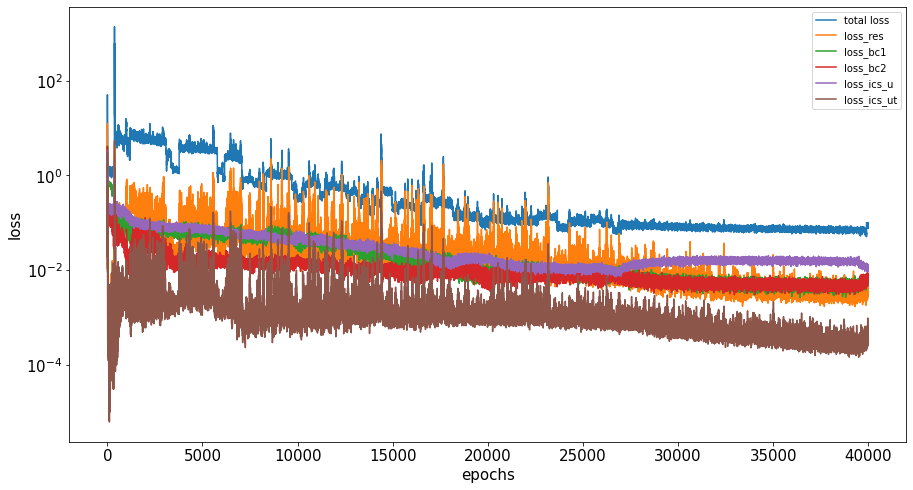

In [4]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), name='coll')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M5'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_r_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        # [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )
        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
            # sess.run(init)

            model = PINN(layers, operator ,  ics_sampler, bcs_sampler, res_sampler, c , mode , sess)
            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                print("full_batch method is used")
                model.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                print("mini_batch method is used")
                model.trainmb(nIter, mbbatch_size)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            u_pred = model.predict_u(X_star)
            r_pred = model.predict_r(X_star)
            # Predictions

            error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
            error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(u_star, 2)

            print('elapsed: {:.2e}'.format(elapsed))

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_r: {:.2e}'.format(error_r))

            model.save_NN()
            model.plt_prediction( t , x , X_star , u_star , u_pred , r_star , r_pred)
            sess.close()  

        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))
        print('Relative L2 error_r: {:.2e}'.format(error_r))

        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_r_list.append(error_r)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list,error_r_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat(os.path.join(model.dirname,""+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_exp"+str(bcbatch_size)+"nIter"+str(nIter)+".mat") , result_dict)

###############################################################################################################################################


Relative L2 error_u: 3.69e-01


TypeError: Dimensions of C (40000, 1) are incompatible with X (200) and/or Y (200); see help(pcolor)

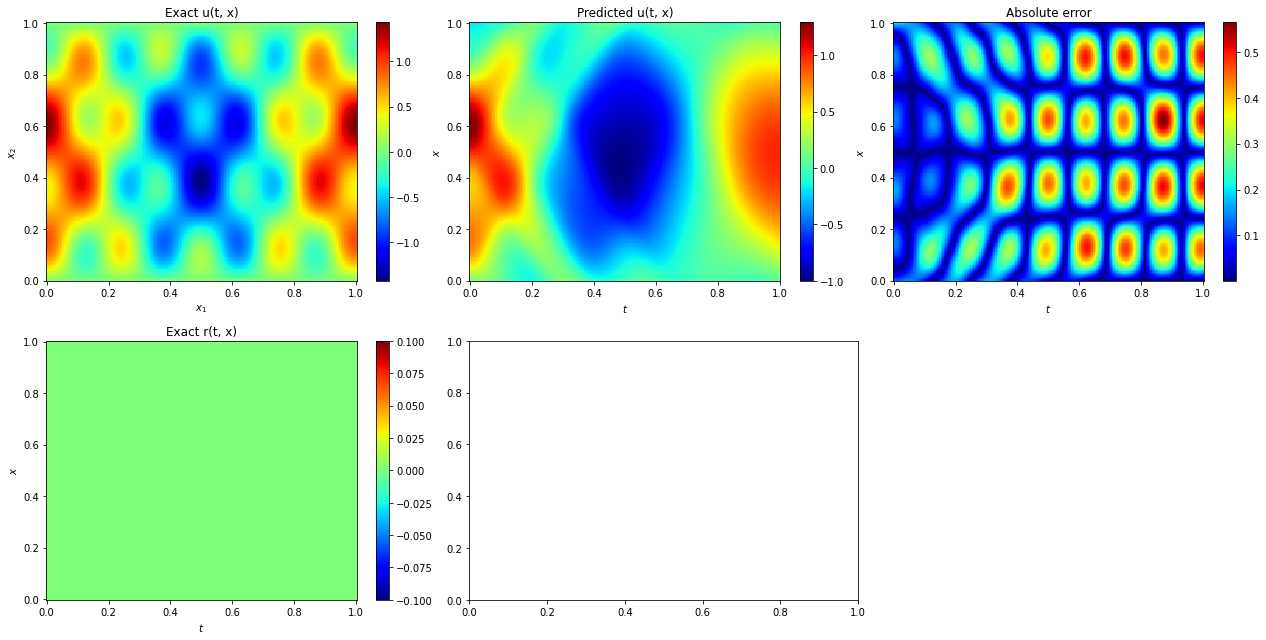

In [5]:
# Predictions
# u_pred = model.predict_u(X_star)
# r_pred = model.predict_r(X_star)

# Predictions

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

# print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))

U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
# R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, r_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - r_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [6]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1
mini_batch method is used
It: 100, Loss: 9.238e-01,  loss_bc1: 6.848e-02, loss_ics_u: 3.931e-01,  Loss_res: 6.576e-04 , Time: 4.89
It: 200, Loss: 6.458e-01,  loss_bc1: 7.923e-02, loss_ics_u: 2.403e-01,  Loss_res: 6.826e-03 , Time: 3.53
It: 300, Loss: 6.600e-01,  loss_bc1: 8.652e-02, loss_ics_u: 2.341e-01,  Loss_res: 1.875e-02 , Time: 3.44
It: 400, Loss: 5.494e-01,  loss_bc1: 6.093e-02, loss_ics_u: 2.009e-01,  Loss_res: 2.586e-02 , Time: 3.43
It: 500, Loss: 5.235e-01,  loss_bc1: 4.314e-02, loss_ics_u: 2.099e-01,  Loss_res: 1.742e-02 , Time: 3.35
It: 600, Loss: 4.532e-01,  loss_bc1: 4.553e-02, loss_ics_u: 1.763e-01,  Loss_res: 9.461e-03 , Time: 3.27
It: 700, Loss: 4.660e-01,  loss_bc1: 4.488e-02, loss_ics_u: 1.662e-01,  Loss_res: 4.375e-02 , Time: 3.38
It: 800, Loss: 4.010e-01,  loss_bc1: 5.502e-02, loss_ics_u: 1.294e-01,  Loss_res: 3.213e-02 , Time: 3.22
It: 900, Loss: 3.889e-01,  loss_bc1: 4.886e-02, loss_ics_u: 1.423e-01,  Loss_res: 6.523e-03 , Time: 3.26

In [ ]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
r_star = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


In [ ]:

import scipy.io

mode = 'M4'
mbbatch_size = 128
ubatch_size = 5000
bcbatch_size = 500
iterations = 40000

time_list = []
error_u_list = []
error_v_list = []
error_p_list = []
    
methods = ["mini_batch" , "full_batch"]
result_dict =  dict((mtd, []) for mtd in methods)

##Mini Batch
time_list = []
error_u_list = [ ]


result_dict["mini_batch"] = [time_list ,error_u_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )

##Full Batch
time_list = []
error_u_list = [ ]
error_v_list = []
error_p_list = []

result_dict["full_batch"] = [time_list ,error_u_list ,error_v_list ,  error_p_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
print("average of error_v_list:" , sum(error_v_list) / len(error_v_list) )
print("average of error_p_list:" , sum(error_p_list) / len(error_p_list) )


scipy.io.savemat("./dataset/1DWave_database_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)



In [ ]:
# Train model
itertaions = 80001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 



**Training Loss**

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [ ]:


# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

In [ ]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
r_star = griddata(X_star, r_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, r_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

**NTK Eigenvalues**

In [ ]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

In [ ]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()

**Evolution of NTK Weights**

In [ ]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_u$')
plt.plot(lam_ut_log, label='$\lambda_{u_t}$')
plt.plot(lam_r_log, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()